In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import GRU, Dense, Activation, Dropout, CuDNNGRU, concatenate, Input
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt
import gc


import pac_autoencoder as pac_ae
import pac_dataset as pac_data

from importlib import reload 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
ROOT_PATH = "/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac"

import os
print(os.listdir(ROOT_PATH))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['test_set.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'test_set_sample.csv', 'test_set_metadata.csv', 'test_set_metadata.csv.zip', 'test_set_sample.csv.zip', 'training_set_metadata.csv', 'data_note.pdf', 'training_set.csv', 'fake030.csv', 'fake010.csv', 'data_note.pdf.zip', 'training_set.csv.zip', 'test_set.csv']


# Load Data

In [2]:
# load metadata
train_metadata = pd.read_csv(os.path.join(ROOT_PATH, 'training_set_metadata.csv'))

# load light data
train_data = pd.read_csv(os.path.join(ROOT_PATH, 'training_set.csv'))

# load test metadata
#test_metadata = pd.read_csv(os.path.join(ROOT_PATH, 'test_set_metadata.csv'))

# load light data
#test_data = pd.read_csv(os.path.join(ROOT_PATH, 'test_set.csv'))

In [3]:
# Submission class_names in the same order
sample_sub = pd.read_csv(os.path.join(ROOT_PATH, 'sample_submission.csv'))
sub_samples_count = sample_sub.shape[0]
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

14

In [4]:
#class_names

In [5]:
#
prep_data_engine = pac_data.PrepData(data=train_data)
prep_train_data = prep_data_engine.transform(train_data)

#
#prep_train_data = pac_data.prep_data(data=train_data)
net_input_data = pac_data.prep_for_net_input(prep_train_data)

#
train_list0 = net_input_data.train_list[0]
train_list0 = train_list0[train_list0.feature_id == 'flux']
label_info = pac_data.get_labels(metadata=train_metadata, train_data_with_object_id=train_list0)

train_list[0] (31392, 75)
train_list[1] (31392, 61)
train_list[2] (31392, 61)
train_list[3] (31392, 61)
train_list[4] (31392, 61)
train_list[5] (31392, 60)
[31392    75]
num_columns[0]: 72
X_train_list[0].shape: (7848, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (7848, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (7848, 58, 4)
num_columns[3]: 58
X_train_list[3].shape: (7848, 58, 4)
num_columns[4]: 58
X_train_list[4].shape: (7848, 58, 4)
num_columns[5]: 57
X_train_list[5].shape: (7848, 57, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)


In [6]:
#{v:k for k, v in label_info.class_map.items()}
orig_labels = sorted(label_info.class_map.keys())

# Load Model

In [7]:
reload(pac_data)
reload(pac_ae)

ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

#weight_table = pac_data.get_weigth_table(classes=label_info.classes, target_map=label_info.target_map)
#print(weight_table)
weight_table = np.ones(14)
model = pac_ae.pac_autoencoder(model_dir=MODEL_DIR, weight_table=weight_table)
#model.load_weights(filepath="/home/hayk/kaggle/pac/logs/pac20181212T1144/pac_1_0344.h5")
model.load_weights(filepath="/home/hayk/kaggle/pac/logs/pac20181212T1749/pac_1_0006.h5")

(?, 9, 6, 128)
u3 shape : (?, 72, 6, 64)
decoded shape : (?, 72, 6, 4)
descriminator d2 shape : (?, 18, 6, 128)
descriminator d3 shape : (?, 9, 6, 256)
descriminator validity shape : (?, 9, 6, 1)
(?, 72, 6, 4)
(?, 9, 6, 128)
classificator shape c2 : (?, 1, 1, 128)
classificator shape rc2 : (?, 128)
14


# Test Model

In [8]:
X_train = net_input_data.X_train

res = model.adversarial_autoencoder.predict(X_train)

In [9]:
yyyyy = res[2].copy()
yyyyy[:,:] = 1.0
print('MULTI WEIGHTED LOG LOSS : %.5f ' % pac_ae.multi_weighted_logloss(label_info.Y,yyyyy))

xxxxx = to_categorical(np.argmax(yyyyy, axis=1), num_classes=14)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % pac_ae.multi_weighted_logloss(label_info.Y,xxxxx))


MULTI WEIGHTED LOG LOSS : -0.00000 
MULTI WEIGHTED LOG LOSS : 32.38016 


In [10]:
from operator import itemgetter
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_info.target_map.shape


counts = Counter(label_info.target_map)
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

#
leb = res[2]
Ypred = np.argmax(leb, axis=1)
Ytest = np.argmax(label_info.Y, axis=1)
np.max(label_info.target_map)

#
cm = confusion_matrix(Ytest, Ypred) #, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

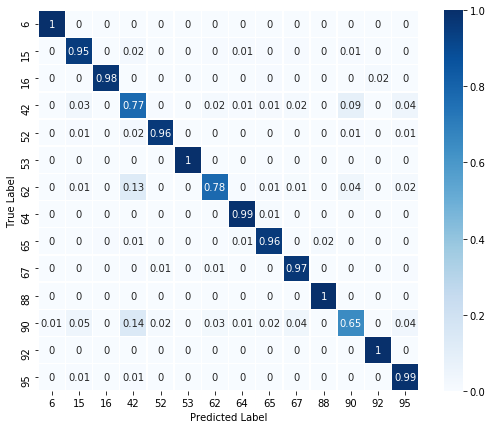

In [11]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=orig_labels, yticklabels=orig_labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

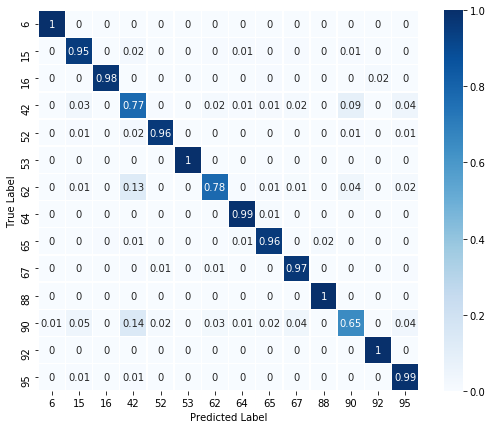

In [12]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=orig_labels, yticklabels=orig_labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')


# Submission

In [13]:

def construct_submission_df(*, pred_res, object_ids, class_names):
    #pred_cat = to_categorical(np.argmax(pred_res, axis=1), num_classes=14)    
    
    #print("prec_cat : {}".format(pred_cat.shape))
    
    preds_df = pd.DataFrame(pred_res, columns=class_names)
    obj_id_df = pd.DataFrame(object_ids, columns=["object_id"])
    
    print("prec_cat : {}".format(obj_id_df.shape))

    preds_df = pd.concat([obj_id_df, preds_df], axis=1)
    
    preds_99 = np.zeros(preds_df.shape[0])
    preds_df['class_99'] = preds_99 
    
    return preds_df

In [14]:
def predict_and_construct_df(*, df, last_series_part, clip_last=True):
    #
    if clip_last:
        aa = df[df.object_id != int(df.iloc[-1].object_id)]
    else:
        aa = df.copy()
    
    #
    if last_series_part is not None:
        aa = pd.concat([last_series_part, aa])
    
    #
    if clip_last:
        last_series_part = df[df.object_id == int(df.iloc[-1].object_id)]
    else:
        last_series_part = None
    
    # 
    #prep_data = pac_data.prep_data(data=aa)
    prep_data = prep_data_engine.transform(aa)

    net_data = pac_data.prep_for_net_input(prep_data)
    
    X_train = net_data.X_train
    res = model.adversarial_autoencoder.predict(X_train)
    
    #
    preds_df = construct_submission_df(pred_res=res[2], object_ids=net_data.object_id, class_names=class_names)
    
    return preds_df, last_series_part

In [15]:
from tqdm import tnrange, tqdm_notebook

from importlib import reload
reload(pac_data)

import time

start = time.time()
chunks = 5000000

prep_data = None
net_data = None

last_series_part = None

count_of_it = int(sub_samples_count / 15000) + 10
print("count_of_it : {}".format(count_of_it))
#with tqdm_notebook(total=count_of_it, desc="Pred on Submision Samples") as pbar:
for i_c, df in enumerate(pd.read_csv(os.path.join(ROOT_PATH, 'test_set.csv'), chunksize=chunks, iterator=True)):
    preds_df, last_series_part = predict_and_construct_df(df=df, last_series_part=last_series_part)
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)

    del preds_df
    gc.collect()
    print("count of it : {}".format(i_c))
        #
        #train_list0 = net_input_data.train_list[0]
        #train_list0 = train_list0[train_list0.feature_id == 'flux']
        #label_info = pac_data.get_labels(metadata=train_metadata, train_data_with_object_id=train_list0)
    
        #del df
    #pbar.update
        
    
preds_df, last_series_part = predict_and_construct_df(df=last_series_part, last_series_part=None, clip_last=False)
preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)


count_of_it : 242
train_list[0] (60548, 75)
train_list[1] (60548, 61)
train_list[2] (60548, 61)
train_list[3] (60548, 61)
train_list[4] (60548, 61)
train_list[5] (60548, 60)
[60548    75]
num_columns[0]: 72
X_train_list[0].shape: (15137, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (15137, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (15137, 58, 4)
num_columns[3]: 58
X_train_list[3].shape: (15137, 58, 4)
num_columns[4]: 58
X_train_list[4].shape: (15137, 58, 4)
num_columns[5]: 57
X_train_list[5].shape: (15137, 57, 4)
(15137, 72, 4)
(15137, 72, 4)
(15137, 72, 4)
(15137, 72, 4)
(15137, 72, 4)
(15137, 72, 4)
prec_cat : (15137, 1)
count of it : 0
train_list[0] (60732, 75)
train_list[1] (60732, 61)
train_list[2] (60732, 61)
train_list[3] (60732, 61)
train_list[4] (60732, 61)
train_list[5] (60732, 60)
[60732    75]
num_columns[0]: 72
X_train_list[0].shape: (15183, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (15183, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (15183, 58, 4)
n

(39098, 72, 4)
(39098, 72, 4)
(39098, 72, 4)
(39098, 72, 4)
(39098, 72, 4)
(39098, 72, 4)
prec_cat : (39098, 1)
count of it : 12
train_list[0] (156384, 23)
train_list[1] (156384, 22)
train_list[2] (156384, 36)
train_list[3] (156384, 36)
train_list[4] (156384, 47)
train_list[5] (156384, 58)
[156384     58]
num_columns[0]: 20
X_train_list[0].shape: (39096, 20, 4)
num_columns[1]: 19
X_train_list[1].shape: (39096, 19, 4)
num_columns[2]: 33
X_train_list[2].shape: (39096, 33, 4)
num_columns[3]: 33
X_train_list[3].shape: (39096, 33, 4)
num_columns[4]: 44
X_train_list[4].shape: (39096, 44, 4)
num_columns[5]: 55
X_train_list[5].shape: (39096, 55, 4)
(39096, 72, 4)
(39096, 72, 4)
(39096, 72, 4)
(39096, 72, 4)
(39096, 72, 4)
(39096, 72, 4)
prec_cat : (39096, 1)
count of it : 13
train_list[0] (156348, 23)
train_list[1] (156348, 21)
train_list[2] (156348, 36)
train_list[3] (156348, 36)
train_list[4] (156348, 47)
train_list[5] (156348, 59)
[156348     59]
num_columns[0]: 20
X_train_list[0].shape: (3

(39094, 72, 4)
(39094, 72, 4)
(39094, 72, 4)
(39094, 72, 4)
(39094, 72, 4)
(39094, 72, 4)
prec_cat : (39094, 1)
count of it : 25
train_list[0] (156192, 23)
train_list[1] (156192, 21)
train_list[2] (156192, 36)
train_list[3] (156192, 36)
train_list[4] (156192, 45)
train_list[5] (156192, 58)
[156192     58]
num_columns[0]: 20
X_train_list[0].shape: (39048, 20, 4)
num_columns[1]: 18
X_train_list[1].shape: (39048, 18, 4)
num_columns[2]: 33
X_train_list[2].shape: (39048, 33, 4)
num_columns[3]: 33
X_train_list[3].shape: (39048, 33, 4)
num_columns[4]: 42
X_train_list[4].shape: (39048, 42, 4)
num_columns[5]: 55
X_train_list[5].shape: (39048, 55, 4)
(39048, 72, 4)
(39048, 72, 4)
(39048, 72, 4)
(39048, 72, 4)
(39048, 72, 4)
(39048, 72, 4)
prec_cat : (39048, 1)
count of it : 26
train_list[0] (156344, 23)
train_list[1] (156344, 22)
train_list[2] (156344, 36)
train_list[3] (156344, 36)
train_list[4] (156344, 47)
train_list[5] (156344, 58)
[156344     58]
num_columns[0]: 20
X_train_list[0].shape: (3

(39070, 72, 4)
(39070, 72, 4)
(39070, 72, 4)
(39070, 72, 4)
(39070, 72, 4)
(39070, 72, 4)
prec_cat : (39070, 1)
count of it : 38
train_list[0] (156164, 23)
train_list[1] (156164, 21)
train_list[2] (156164, 35)
train_list[3] (156164, 36)
train_list[4] (156164, 47)
train_list[5] (156164, 58)
[156164     58]
num_columns[0]: 20
X_train_list[0].shape: (39041, 20, 4)
num_columns[1]: 18
X_train_list[1].shape: (39041, 18, 4)
num_columns[2]: 32
X_train_list[2].shape: (39041, 32, 4)
num_columns[3]: 33
X_train_list[3].shape: (39041, 33, 4)
num_columns[4]: 44
X_train_list[4].shape: (39041, 44, 4)
num_columns[5]: 55
X_train_list[5].shape: (39041, 55, 4)
(39041, 72, 4)
(39041, 72, 4)
(39041, 72, 4)
(39041, 72, 4)
(39041, 72, 4)
(39041, 72, 4)
prec_cat : (39041, 1)
count of it : 39
train_list[0] (156392, 23)
train_list[1] (156392, 22)
train_list[2] (156392, 36)
train_list[3] (156392, 35)
train_list[4] (156392, 47)
train_list[5] (156392, 59)
[156392     59]
num_columns[0]: 20
X_train_list[0].shape: (3

(39076, 72, 4)
(39076, 72, 4)
(39076, 72, 4)
(39076, 72, 4)
(39076, 72, 4)
(39076, 72, 4)
prec_cat : (39076, 1)
count of it : 51
train_list[0] (156336, 23)
train_list[1] (156336, 22)
train_list[2] (156336, 36)
train_list[3] (156336, 36)
train_list[4] (156336, 47)
train_list[5] (156336, 59)
[156336     59]
num_columns[0]: 20
X_train_list[0].shape: (39084, 20, 4)
num_columns[1]: 19
X_train_list[1].shape: (39084, 19, 4)
num_columns[2]: 33
X_train_list[2].shape: (39084, 33, 4)
num_columns[3]: 33
X_train_list[3].shape: (39084, 33, 4)
num_columns[4]: 44
X_train_list[4].shape: (39084, 44, 4)
num_columns[5]: 56
X_train_list[5].shape: (39084, 56, 4)
(39084, 72, 4)
(39084, 72, 4)
(39084, 72, 4)
(39084, 72, 4)
(39084, 72, 4)
(39084, 72, 4)
prec_cat : (39084, 1)
count of it : 52
train_list[0] (156148, 23)
train_list[1] (156148, 22)
train_list[2] (156148, 36)
train_list[3] (156148, 36)
train_list[4] (156148, 47)
train_list[5] (156148, 59)
[156148     59]
num_columns[0]: 20
X_train_list[0].shape: (3

(39109, 72, 4)
(39109, 72, 4)
(39109, 72, 4)
(39109, 72, 4)
(39109, 72, 4)
(39109, 72, 4)
prec_cat : (39109, 1)
count of it : 64
train_list[0] (156372, 23)
train_list[1] (156372, 22)
train_list[2] (156372, 35)
train_list[3] (156372, 36)
train_list[4] (156372, 45)
train_list[5] (156372, 58)
[156372     58]
num_columns[0]: 20
X_train_list[0].shape: (39093, 20, 4)
num_columns[1]: 19
X_train_list[1].shape: (39093, 19, 4)
num_columns[2]: 32
X_train_list[2].shape: (39093, 32, 4)
num_columns[3]: 33
X_train_list[3].shape: (39093, 33, 4)
num_columns[4]: 42
X_train_list[4].shape: (39093, 42, 4)
num_columns[5]: 55
X_train_list[5].shape: (39093, 55, 4)
(39093, 72, 4)
(39093, 72, 4)
(39093, 72, 4)
(39093, 72, 4)
(39093, 72, 4)
(39093, 72, 4)
prec_cat : (39093, 1)
count of it : 65
train_list[0] (156344, 23)
train_list[1] (156344, 21)
train_list[2] (156344, 36)
train_list[3] (156344, 36)
train_list[4] (156344, 47)
train_list[5] (156344, 58)
[156344     58]
num_columns[0]: 20
X_train_list[0].shape: (3

(39061, 72, 4)
(39061, 72, 4)
(39061, 72, 4)
(39061, 72, 4)
(39061, 72, 4)
(39061, 72, 4)
prec_cat : (39061, 1)
count of it : 77
train_list[0] (156256, 23)
train_list[1] (156256, 21)
train_list[2] (156256, 36)
train_list[3] (156256, 36)
train_list[4] (156256, 47)
train_list[5] (156256, 59)
[156256     59]
num_columns[0]: 20
X_train_list[0].shape: (39064, 20, 4)
num_columns[1]: 18
X_train_list[1].shape: (39064, 18, 4)
num_columns[2]: 33
X_train_list[2].shape: (39064, 33, 4)
num_columns[3]: 33
X_train_list[3].shape: (39064, 33, 4)
num_columns[4]: 44
X_train_list[4].shape: (39064, 44, 4)
num_columns[5]: 56
X_train_list[5].shape: (39064, 56, 4)
(39064, 72, 4)
(39064, 72, 4)
(39064, 72, 4)
(39064, 72, 4)
(39064, 72, 4)
(39064, 72, 4)
prec_cat : (39064, 1)
count of it : 78
train_list[0] (156216, 23)
train_list[1] (156216, 21)
train_list[2] (156216, 36)
train_list[3] (156216, 36)
train_list[4] (156216, 45)
train_list[5] (156216, 59)
[156216     59]
num_columns[0]: 20
X_train_list[0].shape: (3

X_train_list[4].shape: (28537, 42, 4)
num_columns[5]: 56
X_train_list[5].shape: (28537, 56, 4)
(28537, 72, 4)
(28537, 72, 4)
(28537, 72, 4)
(28537, 72, 4)
(28537, 72, 4)
(28537, 72, 4)
prec_cat : (28537, 1)
count of it : 90
train_list[0] (4, 15)
train_list[1] (4, 15)
train_list[2] (4, 23)
train_list[3] (4, 28)
train_list[4] (4, 34)
train_list[5] (4, 34)
[ 4 34]
num_columns[0]: 12
X_train_list[0].shape: (1, 12, 4)
num_columns[1]: 12
X_train_list[1].shape: (1, 12, 4)
num_columns[2]: 20
X_train_list[2].shape: (1, 20, 4)
num_columns[3]: 25
X_train_list[3].shape: (1, 25, 4)
num_columns[4]: 31
X_train_list[4].shape: (1, 31, 4)
num_columns[5]: 31
X_train_list[5].shape: (1, 31, 4)
(1, 72, 4)
(1, 72, 4)
(1, 72, 4)
(1, 72, 4)
(1, 72, 4)
(1, 72, 4)
prec_cat : (1, 1)


In [16]:
last_series_part

In [17]:
sub_cons = pd.read_csv('./predictions.csv')
sub_cons.shape

(3492890, 16)

In [18]:
sub_samples_count

3492890

In [19]:
np.unique(sub_cons.object_id.values).shape

(3492890,)

In [21]:
zz = sub_cons.sort_values(by=["object_id"])
zz.to_csv('predictions_sub.csv',  header=True, index=False)

# Construct 

In [20]:
sub_cons = pd.read_csv('./predictions.csv')

In [21]:
preds_y = sub_cons.values[:,1:15].copy()
print(preds_y.shape)

#
preds_99 = np.ones(preds_y.shape[0])
for i in range(preds_y.shape[1]):
    #print(i)
    preds_99 *= (1 - preds_y[:, i])

#
preds_99 = 0.14 * preds_99 / np.mean(preds_99)
preds_99 = preds_99[:, np.newaxis]

#
preds = np.concatenate([preds_y, preds_99], axis=1)
preds = preds / np.sum(preds, axis=1, keepdims=1)

(3492890, 14)


In [22]:
sub_cons.head()

object_id   class_6      class_15      class_16  class_42  class_52  \
0         13  0.000003  1.953532e-07  2.451153e-05  0.007047  0.934042   
1         14  0.000056  8.073186e-05  1.542947e-07  0.501976  0.001061   
2         17  0.000084  1.408956e-05  4.072313e-03  0.000398  0.000002   
3         23  0.000001  6.904510e-07  4.907416e-08  0.098423  0.607747   
4         34  0.001466  3.136256e-05  1.042302e-07  0.018658  0.038391   

       class_53      class_62  class_64  class_65  class_67      class_88  \
0  2.578541e-04  4.018485e-05  0.000001  0.000001  0.000268  2.681542e-08   
1  7.314046e-06  1.791205e-01  0.000013  0.000208  0.110361  7.098126e-05   
2  2.490651e-08  8.827939e-07  0.000013  0.994319  0.000038  8.397471e-04   
3  4.741352e-05  9.399054e-04  0.001415  0.000003  0.002603  4.865011e-08   
4  1.110073e-05  4.424492e-05  0.000042  0.000090  0.001711  4.844482e-04   

   class_90      class_92  class_95  class_99  
0  0.056864  2.378090e-06  0.001449       0.0  
1  0.193617  4.582110e-06  0.013424       0.0  
2  0.000156  2.528937e-06  0.000060       0.0  
3  0.285867  2.953664e-06  0.002951       0.0  
4  0.939005  2.234366e-07  0.000066       0.0

In [23]:
preds.shape

for i, v in enumerate(class_names):
    sub_cons[v] = preds[:,i]

sub_cons["class_99"] = preds[:,-1]

In [24]:
sub_cons.head()

object_id       class_6      class_15      class_16  class_42  class_52  \
0         13  2.616264e-06  1.852256e-07  2.324078e-05  0.006682  0.885618   
1         14  4.490938e-05  6.426343e-05  1.228202e-07  0.399578  0.000844   
2         17  8.390721e-05  1.401932e-05  4.052010e-03  0.000396  0.000002   
3         23  9.046331e-07  5.649088e-07  4.015118e-08  0.080527  0.497242   
4         34  1.395355e-03  2.984483e-05  9.918620e-08  0.017755  0.036533   

       class_53      class_62  class_64  class_65  class_67      class_88  \
0  2.444862e-04  3.810156e-05  0.000001  0.000001  0.000254  2.542523e-08   
1  5.822059e-06  1.425819e-01  0.000010  0.000165  0.087849  5.650185e-05   
2  2.478234e-08  8.783927e-07  0.000013  0.989362  0.000038  8.355606e-04   
3  3.879249e-05  7.690057e-04  0.001158  0.000002  0.002130  3.980424e-08   
4  1.056353e-05  4.210377e-05  0.000040  0.000086  0.001628  4.610043e-04   

   class_90      class_92  class_95  class_99  
0  0.053916  2.254804e-06  0.001374  0.051843  
1  0.154121  3.647409e-06  0.010686  0.203989  
2  0.000155  2.516329e-06  0.000060  0.004985  
3  0.233889  2.416610e-06  0.002414  0.181826  
4  0.893564  2.126238e-07  0.000062  0.048393

In [25]:
np.all(preds == sub_cons.values[:,1:])

True

In [26]:
zz = sub_cons.sort_values(by=["object_id"])
zz.to_csv('predictions_sub.csv',  header=True, index=False)

In [58]:
za = pd.read_csv('./predictions_sub.csv')
np.all(zz == za)

ValueError: Can only compare identically-labeled DataFrame objects

In [65]:
zz.shape

(3492890, 16)

# Exit

In [ ]:


preds_99 = np.ones(yr_m.shape[0])
for i in range(yr_m.shape[1]):
    preds_99 *= (1 - yr_m[:, i])
    
pred_99 = 0.14 * preds_99 / np.mean(preds_99)
pred_99 = pred_99[:, np.newaxis]
    
ex_yr_m = np.concatenate([pred_99, yr_m], axis=1)
ex_yr_m = ex_yr_m / np.sum(ex_yr_m, axis=1, keepdims=1)


In [20]:
sub_cons.head()

object_id   class_6  class_15  class_16  class_42  class_52  class_53  \
0         13  0.000202  0.001484  0.000007  0.397101  0.116910  0.000389   
1         14  0.000167  0.006811  0.000060  0.080166  0.046039  0.000012   
2         17  0.000709  0.009304  0.001625  0.127083  0.002841  0.000012   
3         23  0.000008  0.000684  0.000012  0.356892  0.022328  0.000020   
4         34  0.001750  0.001936  0.000021  0.108142  0.005521  0.000062   

   class_62  class_64  class_65  class_67  class_88  class_90  class_92  \
0  0.159261  0.001402  0.000030  0.179548  0.000023  0.127368  0.000002   
1  0.373795  0.000981  0.004004  0.313561  0.000459  0.128448  0.000025   
2  0.033475  0.000247  0.149781  0.038544  0.001126  0.632778  0.000048   
3  0.056944  0.001417  0.000169  0.071823  0.000052  0.432328  0.000007   
4  0.206313  0.000094  0.000752  0.045625  0.000055  0.625687  0.000002   

   class_95  class_99  
0  0.016272       0.0  
1  0.045472       0.0  
2  0.002427       0.0  
3  0.057316       0.0  
4  0.004041       0.0

In [32]:
sample_sub = pd.read_csv(os.path.join(ROOT_PATH, 'sample_submission.csv'))
#sample_sub

In [20]:
z = pd.read_csv('predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions.csv', index=True)

1
0


In [34]:
#z

In [30]:
sub_cons.object_id.values == sample_sub.object_id.values

array([ True,  True,  True, ..., False, False, False])

In [27]:
sample_sub.object_id.shape

(3492890,)

In [37]:
ch = zz.object_id.values == sample_sub.object_id.values

In [45]:
sample_sub.head()

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0         13        0         0         0         0         0         0   
1         14        0         0         0         0         0         0   
2         17        0         0         0         0         0         0   
3         23        0         0         0         0         0         0   
4         34        0         0         0         0         0         0   

   class_62  class_64  class_65  class_67  class_88  class_90  class_92  \
0         0         0         0         0         0         1         0   
1         0         0         0         0         0         1         0   
2         0         0         0         0         0         1         0   
3         0         0         0         0         0         1         0   
4         0         0         0         0         0         1         0   

   class_95  class_99  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0

In [46]:
zz

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0         13      0.0       0.0       0.0       1.0       0.0       0.0   
1         14      0.0       0.0       0.0       0.0       0.0       0.0   
2         17      0.0       0.0       0.0       0.0       0.0       0.0   
3         23      0.0       0.0       0.0       0.0       0.0       0.0   
4         34      0.0       0.0       0.0       0.0       0.0       0.0   

   class_62  class_64  class_65  class_67  class_88  class_90  class_92  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       1.0       0.0   

   class_95  class_99  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0